Здесь собраны и тестятся все применяемые в рамках текущей задачи методы

In [2]:
# ! git clone -b ml_and_stat_methods https://github.com/mipt-nd/novelty-detection.git
# %cd novelty-detection/

In [4]:
# ! pip install pyod -q
# ! pip install suod -q

In [5]:
import os
import random
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for statistics
from scipy.stats import kstest

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# ml methods
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# ml_semisupervised_methods
from sklearn.neighbors import LocalOutlierFactor

#claster methods
# from sklearn.cluster import DBSCAN

# pyod
from pyod.models.ecod import ECOD
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
SEED = 42
seed_everything(SEED)

# Datasets

In [6]:
# Синтетически сгенерированные нормально распределенные данные
def make_norm_data(rows, columns, noise_percent=0.05):
    data_norm = pd.DataFrame(data=np.random.normal(
                            loc=0, scale=1, size=(rows, columns)))
    noise = pd.DataFrame(data=np.random.uniform(
                            low=-6, high=6, size=(int(data_norm.shape[0]*noise_percent), data_norm.shape[1])))

    data_noise = pd.DataFrame()
    for feature in noise.columns:
        filter = (
            (noise[feature] < data_norm[feature].min())
            | (noise[feature] > data_norm[feature].max())
            )
        data_noise = pd.concat([data_noise, noise[filter]])
    data_noise = data_noise.drop_duplicates()
    data_norm['anomaly'] = 0
    data_noise['anomaly'] = 1

    df_norm = pd.concat((data_norm, data_noise))
    return df_norm

df_norm = make_norm_data(1000, 8)
df_norm

,0,1,2,3,4,5,6,7,anomaly
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,0
1,-0.469474,0.542560,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,0
2,-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748,0
3,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278,0
4,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0
...,...,...,...,...,...,...,...,...,...
32,0.063984,1.772509,0.031678,-0.098264,-3.938531,-2.655435,-4.093768,-3.652004,1
38,-2.800126,2.593122,-1.268901,2.124984,-0.288220,5.925277,2.746826,5.429896,1
5,2.151800,-0.353991,-1.345218,-1.488481,1.680586,-0.062468,4.189587,4.496424,1
37,-2.554173,0.008819,-0.528646,-1.866863,2.324896,3.114742,4.235808,5.674279,1


In [7]:
# SKAB data

all_files=[]
for root, dirs, files in os.walk("data_labeled/SKAB/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# формируем датафрейм
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    # print(path, df.shape)
    dfs.append(df)
# print('Features:')
# for col in dfs[2].columns:
#     print('\t',col)
dfs = [df for df in dfs if df.shape[1] == 10]
df_skab = pd.concat(dfs)
# print(df_skab.shape)
df_skab = df_skab.drop_duplicates()
df_skab = df_skab.drop('changepoint', axis=1).sort_index()
display(df_skab)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
datetime,,,,,,,,,
2020-02-08 16:06:48,0.213628,0.266664,2.588900,-0.273216,89.1732,29.3477,231.257,125.3240,0.0
2020-02-08 16:06:49,0.214988,0.267634,2.994500,0.382638,89.3237,29.3409,234.948,125.6780,0.0
2020-02-08 16:06:50,0.212976,0.268121,2.849810,0.054711,88.9180,29.3450,208.112,125.3240,0.0
2020-02-08 16:06:51,0.214286,0.267545,2.884770,-0.273216,89.0148,29.3459,206.579,125.6780,0.0
2020-02-08 16:06:52,0.213402,0.266691,2.595010,0.382638,88.9571,29.3462,223.472,125.3240,0.0
...,...,...,...,...,...,...,...,...,...
2020-03-09 17:14:04,0.026853,0.038926,0.740614,0.054711,69.6371,24.1045,237.276,32.0451,0.0
2020-03-09 17:14:05,0.027067,0.038430,0.988875,0.054711,69.6731,24.1046,230.729,32.9562,0.0
2020-03-09 17:14:07,0.027582,0.038836,0.588439,0.054711,69.6959,24.1020,233.443,32.0000,0.0


In [8]:
# labeled data

df_pageblocks = pd.read_csv('data_labeled/pageblocks_16.csv')
df_pageblocks = df_pageblocks.rename(columns={'label': 'anomaly'})
df_shuttle = pd.read_csv('data_labeled/shuttle_16.csv')
df_shuttle = df_shuttle.rename(columns={'label': 'anomaly'})
print('df_pageblocks')
display(df_pageblocks.head())
print('df_shuttle')
display(df_shuttle.head())

df_pageblocks


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,anomaly
0,0.004981,0.010870,0.000194,0.002594,0.367089,0.634328,0.000268,0.000212,0.000347,0.001557,0
1,0.006227,0.010870,0.000243,0.002160,0.397679,0.873134,0.000525,0.000333,0.000650,0.001246,0
2,0.006227,0.030797,0.000701,0.005574,0.247890,0.723881,0.000692,0.000727,0.001583,0.001869,0
3,0.004981,0.010870,0.000194,0.002594,0.336498,0.726013,0.000672,0.000182,0.000412,0.000623,0
4,0.006227,0.003623,0.000076,0.000918,0.472574,0.940299,0.000252,0.000061,0.000217,0.000934,0


df_shuttle


,att1,att2,att3,att4,att5,att6,att7,att8,att9,anomaly
0,0.214286,0.607955,0.12766,0.020145,0.207865,0.088428,0.347222,0.746875,0.737113,1
1,0.085714,0.607955,0.12766,0.020145,0.207865,0.088428,0.458333,0.746875,0.716495,1
2,0.200000,0.607955,0.12766,0.020145,0.067416,0.088428,0.361111,0.912500,0.871134,1
3,0.085714,0.602273,0.12766,0.020145,0.207865,0.088428,0.472222,0.746875,0.716495,1
4,0.185714,0.653409,0.12766,0.020145,0.067416,0.088428,0.375000,0.912500,0.865979,1


In [19]:
datasets = {
    'df_norm': {
        'df': df_norm,
    },
    'df_skab': {
        'df': df_skab,
        'time_series': True,
    },
    'df_pageblocks': {
        'df': df_pageblocks,
    },
    'df_shuttle': {
        'df': df_shuttle,
    },
}

# Метрики

In [11]:
# f1_score
def score_metrics(real_outliers, pred_outliers, output_dict=False):
    scores = {}
    # scores['f1_score'] = f1_score(real_outliers, pred_outliers)
    scores = classification_report(real_outliers, pred_outliers, output_dict=output_dict)
    return scores

# Статический метод выявления выбросов (3 сигма)

In [12]:
def check_kstest(df, alpha=0.01):
    columns = list(df.columns)
    cols_with_pos_res = []
    for col in columns:
        if kstest(df[col], 'norm').pvalue > alpha:
            cols_with_pos_res.append(col)
    return cols_with_pos_res

def outliers_z_score(data, feature):
    x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'Признак {feature}. Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    return outliers

def z_score_method(df):
    """
    Метод работает с нормально распределенными данными,
    при чем с небольшим (до 10%) количеством выбросов.
    С ненормально распределенными данными не работает.
    """
    norm_cols = check_kstest(df)
    if norm_cols:
        print('z_score_method')
        outliers = pd.DataFrame()
        for col in norm_cols:
            outliers = pd.concat((outliers, outliers_z_score(df, col)))
        outliers = outliers.drop_duplicates()
        outliers['anomaly_preds'] = 1
        df_with_marked_outliers = df.merge(outliers, how='outer').fillna(0)
        return outliers, df_with_marked_outliers
    else:
        print('The data are not normally distributed')
        return None, df

def stat_method(X, y):
    outliers, X = z_score_method(X)
    if outliers is not None:
        print(score_metrics(y, X['anomaly_preds']))

# Preprocessing

In [13]:
def preprocessing(df):
    df = df.drop_duplicates()
    X = df.copy()
    y = X.pop('anomaly')

    # preprocessing
    columns = list(X.columns)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X, columns=columns)
    return X, y


# ML методы

In [14]:
def ml_method(X, y, model, params):
    grid = GridSearchCV(
                estimator=model(),
                param_grid=params,
                scoring='f1_micro',
                return_train_score=True).fit(X, y)
    pred = grid.best_estimator_.predict(X)
    pred[pred != -1] = 0
    pred[pred == -1] = 1
    print(grid.best_estimator_)
    print(score_metrics(y, pred))

In [15]:
ml_models = {}
ml_models['IsolationForest'] = {
    'model': IsolationForest,
    'params': {
        'n_estimators': [50, 100, 500],
        'bootstrap': [True, False],
        }
    }
ml_models['OneClassSVM'] = {
    'model': OneClassSVM,
    'params': {
        'nu': [0.001, 0.01, 0.1, 0.5, 1],
    }
}

In [ ]:
for df_name, dataset in datasets.items():
    df = dataset['df']
    print(df_name)
    X, y = preprocessing(df)
    stat_method(X, y)
    for model in ml_models:
        ml_method(X, y, ml_models[model]['model'], 
                        ml_models[model]['params'])
    print('-' * 10)

df_norm
z_score_method
Признак 1. Число выбросов по методу z-отклонения: 16
Признак 3. Число выбросов по методу z-отклонения: 17
Признак 4. Число выбросов по методу z-отклонения: 18
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1000
           1       0.97      0.72      0.83        50

    accuracy                           0.99      1050
   macro avg       0.98      0.86      0.91      1050
weighted avg       0.99      0.99      0.98      1050

IsolationForest(bootstrap=True, n_estimators=50)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       0.88      1.00      0.93        50

    accuracy                           0.99      1050
   macro avg       0.94      1.00      0.97      1050
weighted avg       0.99      0.99      0.99      1050

OneClassSVM(nu=0.001)
              precision    recall  f1-score   support

           0       0.98      0.97     

# ECOD

In [ ]:
for df_name, dataset in datasets.items():
    df = dataset['df']
    print(df_name)
    clf = ECOD()
    X, y = preprocessing(df)
    clf.fit(X)
    pred = clf.predict(X)
    print(score_metrics(y, pred))

df_norm
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1000
           1       0.48      1.00      0.65        50

    accuracy                           0.95      1050
   macro avg       0.74      0.97      0.81      1050
weighted avg       0.98      0.95      0.96      1050

df_skab
              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80     23853
         1.0       0.71      0.20      0.31     13067

    accuracy                           0.69     36920
   macro avg       0.70      0.58      0.56     36920
weighted avg       0.69      0.69      0.63     36920

df_pageblocks
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4883
           1       0.43      0.46      0.45       510

    accuracy                           0.89      5393
   macro avg       0.69      0.70      0.69      5393
weighted avg       0.89      0.89      0.89 

# SUOD

In [ ]:
# # initialized a group of outlier detectors for acceleration
# detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
#                  LOF(n_neighbors=25), LOF(n_neighbors=35),
#                  COPOD(), IForest(n_estimators=100),
#                  IForest(n_estimators=200)]

# # decide the number of parallel process, and the combination method
# # then clf can be used as any outlier detection model
# clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
#            verbose=False)

# X, y = preprocessing(df_skab)
# clf.fit(X)
# pred = clf.predict(X)
# print(score_metrics(y, pred))

# LocalOutlierFactor

In [ ]:
for df_name, dataset in datasets.items():
    df = dataset['df']
    print(df_name)
    df_cleaned = df[df['anomaly'] == 0]
    df_anomaly = df[df['anomaly'] == 1]

    df_train, df_test = train_test_split(
                df_cleaned, test_size=0.5, random_state=SEED)
    df_test = pd.concat([df_test, df_anomaly])
    df_test = shuffle(df_test)

    X_train, _ = preprocessing(df_train)
    X_test, y_test = preprocessing(df_test)

lof = LocalOutlierFactor(novelty=True)
    lof.fit(X_train)
    pred = lof.predict(X_test)
    pred[pred != -1] = 0
    pred[pred == -1] = 1
    print(score_metrics(y_test, pred))

df_norm
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      0.96      0.98        50

    accuracy                           1.00       550
   macro avg       1.00      0.98      0.99       550
weighted avg       1.00      1.00      1.00       550

df_skab
              precision    recall  f1-score   support

         0.0       0.48      0.68      0.56     11927
         1.0       0.53      0.33      0.41     13067

    accuracy                           0.50     24994
   macro avg       0.51      0.50      0.48     24994
weighted avg       0.51      0.50      0.48     24994

df_pageblocks
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2442
           1       0.60      0.67      0.63       510

    accuracy                           0.87      2952
   macro avg       0.76      0.79      0.78      2952
weighted avg       0.87      0.87      0.87 

# PCA

df_norm


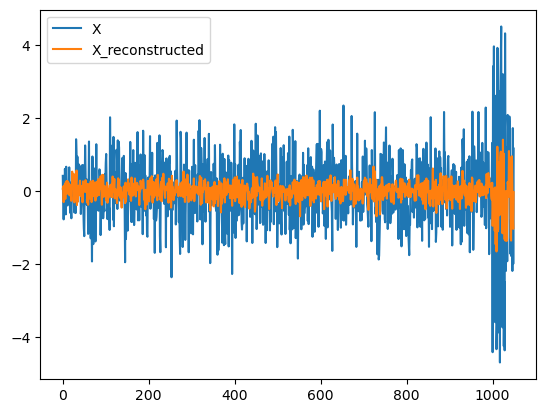

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       0.92      0.98      0.95        50

    accuracy                           1.00      1050
   macro avg       0.96      0.99      0.97      1050
weighted avg       1.00      1.00      1.00      1050

----------
df_skab


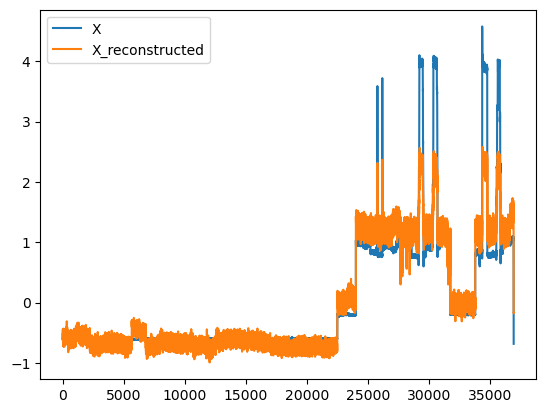

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79     23851
         1.0       0.68      0.10      0.17     13067

    accuracy                           0.66     36918
   macro avg       0.67      0.54      0.48     36918
weighted avg       0.67      0.66      0.57     36918

----------
df_pageblocks


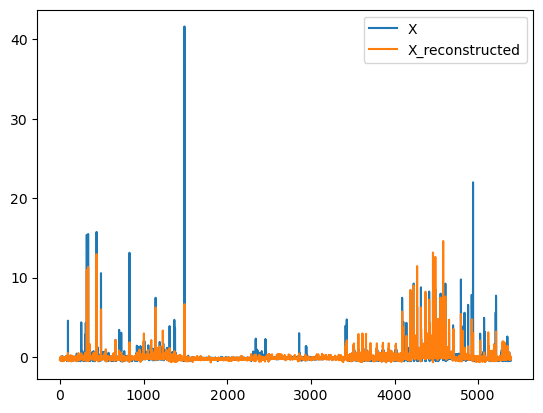

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4883
           1       0.77      0.41      0.54       510

    accuracy                           0.93      5393
   macro avg       0.86      0.70      0.75      5393
weighted avg       0.93      0.93      0.92      5393

----------
df_shuttle


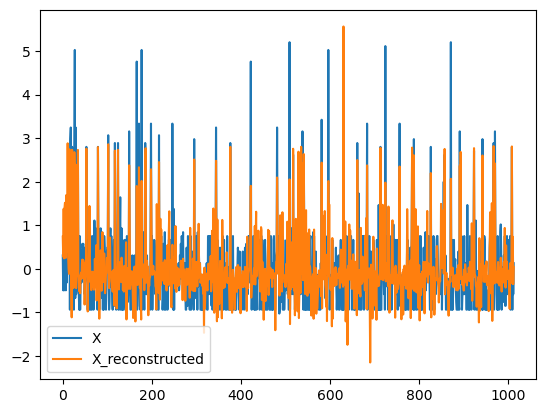

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1000
           1       0.25      1.00      0.41        13

    accuracy                           0.96      1013
   macro avg       0.63      0.98      0.69      1013
weighted avg       0.99      0.96      0.97      1013

----------


In [ ]:
for df_name, dataset in datasets.items():
    df = dataset['df']
    print(df_name)
    X, y = preprocessing(df)

    # Apply PCA to reduce the dimensionality of the data
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Reconstruct the data using the reduced dimensions
    X_reconstructed = pca.inverse_transform(X_pca)
    
    # visualize and compare first columns of original and reconstructed X
    # plt.plot(X.iloc[:, 0], label='X')
    # plt.plot(X_reconstructed[:,0], label='X_reconstructed')
    # plt.legend()
    # plt.show()

    # Calculate the residuals
    residuals = np.linalg.norm(X - X_reconstructed, axis=1)

    # Specify a threshold value for the residuals to distinguish between normal and anomalous data points
    threshold = np.percentile(residuals, 95)

    # Identify the anomalous data points that have residuals greater than the threshold value
    anomalies = X[residuals > threshold]
    anomalies['anomaly'] = 1
    X['anomaly'] = anomalies['anomaly']
    X['anomaly'] = X['anomaly'].fillna(0)

    print(score_metrics(y, X['anomaly']))
    
    print('-' * 10)

# Применение теста Дики-Фуллера ко временному ряду

In [20]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Проверка стационарности ряда
for df_name, dataset in datasets.items():
    df = dataset['df']
    time_series = dataset.get('time_series', False)
    if not time_series:
        continue
    print(df_name)
    for col in df.columns:
        result = adfuller(df[col])
        # print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        # print('Critical Values:')
        # for key, value in result[4].items():
        #     print('\t%s: %.3f' % (key, value))

        # Применение теста Дики-Фуллера к ряду
        result = adfuller(df[col])
        if result[1] < 0.05:
            print(f'Ряд {col} стационарен')
        else:
            print(f'Ряд {col} нестационарен. Возможно, есть аномалии в данных')
    print('-'*10)

df_skab
p-value: 0.000238
Ряд Accelerometer1RMS стационарен
p-value: 0.001528
Ряд Accelerometer2RMS стационарен
p-value: 0.000333
Ряд Current стационарен
p-value: 0.000000
Ряд Pressure стационарен
p-value: 0.608690
Ряд Temperature нестационарен. Возможно, есть аномалии в данных
p-value: 0.154104
Ряд Thermocouple нестационарен. Возможно, есть аномалии в данных
p-value: 0.000000
Ряд Voltage стационарен
p-value: 0.214253
Ряд Volume Flow RateRMS нестационарен. Возможно, есть аномалии в данных
p-value: 0.000000
Ряд anomaly стационарен
----------
